In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,UpSampling2D,Flatten,Dropout,Dense,BatchNormalization,Reshape

In [6]:
import os

Rx_train=[]
Ry_train=[]
Rx_test=[]
Ry_test=[]

path_train_low='../dataSets/ref/our485/low/'
path_train_high='../dataSets/ref/our485/high/'
path_test_low='../dataSets/ref/eval15/low/'
path_test_high='../dataSets/ref/eval15/high/'

print('\nLoding Train dataset :')
i=0;

def denoiseScaleGray(img):
    return cv2.fastNlMeansDenoising(np.array(img,dtype='uint8'),None,2,6,20)/255.

for img in os.listdir(path_train_low):
    img_low_path=os.path.join(path_train_low, img)
    img_high_path=os.path.join(path_train_high, img)
    
    img_low=load_img(img_low_path, target_size=(128,128))
    img_low=img_to_array(img_low)
    
    i=i+1
    print("{:.2f}".format(i/4.89)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(128,128))
    img_high=img_to_array(img_high)
    
    Rx,Gx,Bx=cv2.split(img_low)
    Rx=denoiseScaleGray(Rx)
    #Gx=denoiseScaleGray(Gx)
    #Bx=denoiseScaleGray(Bx)
    
    Ry,Gy,By=cv2.split(img_high)
    Ry=denoiseScaleGray(Ry)
    #Gy=denoiseScaleGray(Gy)
    #By=denoiseScaleGray(By)
    
    Rx_train.append(Rx)
    Ry_train.append(Ry)
    
print('\nLoding Test dataset :')
i=0;
for img in os.listdir(path_test_low):
    img_low_path=os.path.join(path_test_low, img)
    img_high_path=os.path.join(path_test_high, img)
    
    img_low=load_img(img_low_path, target_size=(128,128))
    img_low=img_to_array(img_low)
    
    i=i+1
    print("{:.2f}".format(i/0.14)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(128,128))
    img_high=img_to_array(img_high)
    
    Rx,Gx,Bx=cv2.split(img_low)
    Rx=denoiseScaleGray(Rx)
    #Gx=denoiseScaleGray(Gx)
    #Bx=denoiseScaleGray(Bx)
    
    Ry,Gy,By=cv2.split(img_high)
    Ry=denoiseScaleGray(Ry)
    #Gy=denoiseScaleGray(Gy)
    #By=denoiseScaleGray(By)
    
    Rx_test.append(Rx)
    Ry_test.append(Ry)

Rx_train=np.expand_dims(np.array(Rx_train, dtype="float32"),3)
Ry_train=np.expand_dims(np.array(Ry_train, dtype="float32"),3)

Rx_test=np.expand_dims(np.array(Rx_test, dtype="float32"),3)
Ry_test=np.expand_dims(np.array(Ry_test, dtype="float32"),3)


Loding Train dataset :
100.00 %
Loding Test dataset :


In [19]:
Ry_train[1].shape

(128, 128, 1)

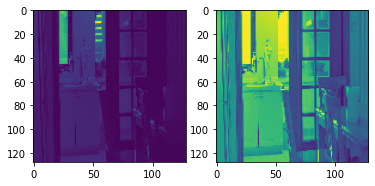

In [15]:
fig=plt.figure()

f=fig.add_subplot(1,2,1)
s=fig.add_subplot(1,2,2)

f.imshow(Rx_train[2])
s.imshow(Ry_train[2])

In [17]:
model=Sequential()

model.add(Conv2D(64,(3,3),padding='same',activation='elu',input_shape=(128,128,1)))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3),padding='same',activation='elu'))
model.add(Conv2D(32,(3,3),padding='same',activation='elu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(1,(1,1),padding='same',activation='sigmoid'))

model.summary()

ValueError: Input 0 of layer conv2d_4 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 128, 128]

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint=ModelCheckpoint('models/ref/ref_cnn.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1
                          )
earlystop=EarlyStopping(monitor='val_loss',
                        patience=6,
                        min_delta=0,
                        restore_best_weights=True,
                        verbose=1
                       )
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=5,
                            min_delta=0.0001,
                            verbose=1
                           )
callbacks=[checkpoint,earlystop,reduce_lr]

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.RMSprop(0.05),
              metrics=['accuracy']
             )

history=model.fit(
    x=Rx_train,
    y=Ry_train,
    batch_size=32,
    epochs=50,
    validation_data=(Rx_test,Ry_test),
    callbacks=callbacks
    )

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.0036 
Epoch 00001: val_loss improved from inf to 0.28463, saving model to models/ref\ref_cnn.h5
16/16 [==============================] - 163s 10s/step - loss: 0.2705 - accuracy: 0.0036 - val_loss: 0.2846 - val_accuracy: 0.0376
Epoch 2/50
10/16 [=================>............] - ETA: 1:02 - loss: 0.2684 - accuracy: 0.0036

KeyboardInterrupt: 

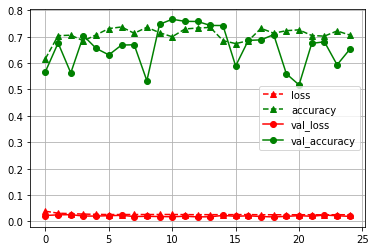

In [11]:
plt.grid()

plt.plot(history.history['loss'],'--^r',label="loss")
plt.plot(history.history['accuracy'],'--^g',label='accuracy')
plt.plot(history.history['val_loss'],'-or',label='val_loss')
plt.plot(history.history['val_accuracy'],'-og',label='val_accuracy')
plt.legend()

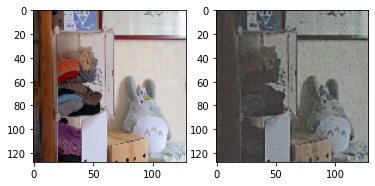

In [31]:
fig=plt.figure()

def check_result(n):
    fig.add_subplot(1,2,1).imshow(y_test[n])
    fig.add_subplot(1,2,2).imshow(model.predict(x_test)[n])

check_result(4)

In [ ]:
# #img=cv2.imread('../dataSets/pic2.jpeg')
# img=np.array(model.predict(x_test)[2]*255,dtype=np.uint8)
# R,G,B=cv2.split(img)

# # equ_R=cv2.equalizeHist(R)
# # equ_G=cv2.equalizeHist(G)
# # equ_B=cv2.equalizeHist(B)

# clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10,10))
# equ_R = clahe.apply(R)
# equ_G = clahe.apply(G)
# equ_B = clahe.apply(B)

# equ=cv2.merge((equ_R,equ_G,equ_B))

# res = np.hstack((img,equ))

# cv2.imshow('img',res)
# cv2.waitKey(5000)
# cv2.destroyWindow('img')